# RNN BUILD

* Først hente og rense data ved bruk av eget lib
* Så sette opp en modell
* Trene og validere -> Deretter teste på ny data
* Lagre modellen

Ops ops: Modellen kan kun bukes på data med 3 dimensjoner. Det betyr at det alltid på komme i en sekvens på minimum (2, 30, 5)

In [1]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from lib.rens import rens
from lib.create_dataset import create_dataset
from lib.make_ready import make_ready


In [2]:
# Pickle save and load premake file.
#import pickle
#with open('premade_data/79dager.pkl', 'wb') as f:
#    pickle.dump(data, f)
    
# Load
with open('premade_data/79dager.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
def r2_score_nn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def add_data(word):
    ordet = 'data/' + word
    return ordet

In [4]:
indikatorer = ['macd', 'rsi_6', 'rsi_10', 'rsi_20', 'rsi_60', 
               'open_4_sma', 'open_8_sma', 'open_15_sma', 'open_16_sma', 'open_30_sma', 'open_60_sma',
               'trix', 'open_10_trix', 'open_30_trix', 'open_60_trix', 
               'wr_10', 'wr_20', 'wr_60', 'open_30_mstd', 'vr_30_sma',
               'volume', 'dma', 'atr_30', 'adx_30_ema', 'adx', 'adxr', 'cci_30']

In [5]:
filer = list(map(add_data, os.listdir('data/')))[0:5] # test 54:60 mellom 10 og 14 er noe feil
data = make_ready().use_stockstats(filer, indikatorer)

In [6]:
data[0]['rsi_6'] = data[0]['rsi_6'].fillna(5)

In [7]:
data[0]['rsi_6']

0      100.000000
1      100.000000
2      100.000000
3      100.000000
4      100.000000
          ...    
372     57.358367
373     57.358367
374     57.358367
375     29.272661
376     65.129257
Name: rsi_6, Length: 377, dtype: float64

In [8]:
data[0].columns

Index(['tid', 'open', 'close', 'high', 'low', 'volume', 'amount', 'macd',
       'macds', 'macdh', 'close_-1_s', 'close_-1_d', 'rs_6', 'rsi_6', 'rs_10',
       'rsi_10', 'rs_20', 'rsi_20', 'rs_60', 'rsi_60', 'open_4_sma',
       'open_8_sma', 'open_15_sma', 'open_16_sma', 'open_30_sma',
       'open_60_sma', 'trix', 'open_10_trix', 'open_30_trix', 'open_60_trix',
       'wr_10', 'wr_20', 'wr_60', 'open_30_mstd', 'change', 'vr', 'vr_30_sma',
       'close_10_sma', 'close_50_sma', 'dma', 'tr', 'atr_30', 'high_delta',
       'um', 'low_delta', 'dm', 'pdm', 'pdm_14_ema', 'pdm_14', 'atr_14',
       'pdi_14', 'pdi', 'mdm', 'mdm_14_ema', 'mdm_14', 'mdi_14', 'mdi',
       'dx_14', 'dx', 'dx_6_ema', 'adx', 'adx_6_ema', 'adxr', 'adx_30_ema',
       'middle', 'middle_30_sma', 'cci_30', 'sma8-16', 'sma30_derivert',
       'sma15_derivert', 'derivert'],
      dtype='object')

In [9]:
def prepare_data_for_training(data, indikatorer):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[indikatorer],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.extend(datax)
        datayes.extend(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)


def prepare_data_for_test(data, indikatorer):
    dataxes = []
    datayes = []
    sanne = []
    look_back=30
    look_forward=10

    for one_stock in data:
        datax, datay, sann = create_dataset().create(one_stock[indikatorer],
                                      one_stock.sma30_derivert, look_back=look_back, look_forward=look_forward)
        dataxes.append(datax)
        datayes.append(datay)
        sanne.append(sann)

    return np.array(dataxes), np.array(datayes)
    
 
dataxes, datayes = prepare_data_for_training(data, indikatorer)


In [10]:
# split in train and val for training
X_train, X_test, y_train, y_test = train_test_split(dataxes, datayes, test_size=0.33, shuffle=True, random_state=42)
X_train.shape

(897, 30, 27)

## Lage modellen
Bruker LSTM. gode greier. Har ikke gridsearched eller kfold.

In [14]:
model = Sequential()

model.add(LSTM(units=64, input_dim=X_train.shape[2], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_nn])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 64)          23552     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 57,226
Trainable params: 57,226
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=64, verbose=1)

Epoch 1/60
15/15 [==============================] - 2s 138ms/step - loss: 0.2715 - mae: 0.3754 - r2_score_nn: 0.2010 - val_loss: 0.1396 - val_mae: 0.2813 - val_r2_score_nn: 0.5950
Epoch 2/60
15/15 [==============================] - 1s 40ms/step - loss: 0.1632 - mae: 0.3011 - r2_score_nn: 0.3187 - val_loss: 0.1140 - val_mae: 0.2580 - val_r2_score_nn: 0.6671
Epoch 3/60
15/15 [==============================] - 1s 40ms/step - loss: 0.1351 - mae: 0.2753 - r2_score_nn: 0.5138 - val_loss: 0.1006 - val_mae: 0.2442 - val_r2_score_nn: 0.7042
Epoch 4/60
15/15 [==============================] - 1s 39ms/step - loss: 0.1163 - mae: 0.2572 - r2_score_nn: 0.6539 - val_loss: 0.0860 - val_mae: 0.2250 - val_r2_score_nn: 0.7468
Epoch 5/60
15/15 [==============================] - 1s 40ms/step - loss: 0.1019 - mae: 0.2421 - r2_score_nn: 0.4047 - val_loss: 0.0811 - val_mae: 0.2188 - val_r2_score_nn: 0.7598
Epoch 6/60
15/15 [==============================] - 1s 40ms/step - loss: 0.0939 - mae: 0.2328 - r2_score

In [13]:
X_train.shape

(897, 30, 27)

### Plotte validation kurve

max val_r2 0.9326466917991638


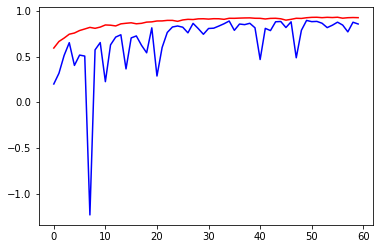

In [17]:
plt.plot(history.history['r2_score_nn'], c='b')
plt.plot(history.history['val_r2_score_nn'], c='r')
#plt.xlim(50,100)
#plt.ylim(0.0, 0.025)
print(f"max val_r2 {np.max(history.history['val_r2_score_nn'])}")

### Gjennomføre en tes 
Henter helt nye data for å gjennomføre en test på modellen.

In [21]:
filer = list(map(add_data, os.listdir('data/')))[55:60] # test 54:60
data_test = make_ready().use_stockstats(filer, indikatorer)
dataxes, datayes = prepare_data_for_test(data_test, indikatorer)

<ipython-input-9-fc11377b225f>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(dataxes), np.array(datayes)


In [ ]:
dataxes.shape

In [ ]:
pred = []
for x in dataxes:
    pred.append(model.predict(x))

pred = np.array(pred)

In [ ]:
for i in range(len(pred)):
    print(f"rscore for one of it {r2_score(pred[i], datayes[i])}")
    

In [ ]:
for i, p in enumerate(pred):
    for j, y in enumerate(p):
        
    #print(p.shape)
        plt.plot(range(30+j,40+j), datayes[i][j], c='blue', linewidth=.5)
        plt.plot(range(30+j,40+j), y, c='red')
    plt.show()

In [ ]:
plt.plot(data[0]['open'])

## Save model

In [ ]:
# Save model

model.save('models/rnn_model.h5')

In [ ]:
!dir